In [1]:
from typing import Tuple, List
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random as rand

from node import Node
from heap import MinHeap

In [6]:
class RandomisedSet:
    """
    A randomised set which enables the insertion, deletion and random extraction of edges in O(1) (constant) time.

    Attributes:
        edges: A list storing non-duplicate edges that are not connected in the graph.
        edge_to_idx: A hashmap mapping the edges to the indices they are stored in the edges list.

    Methods:
        add_edges_from_node: Add available edges connected to all nodes from the input node.
        add_edge: Add an edge to the randomised set.
        remove_edge: Remove an edge from the randomised set.
        get_random_edge: Extract a random available edge.
    """
    def __init__(self) -> None:
        """
        Construct the attributes of the set.
        """
        self.edges = []
        self.edge_to_idx = {}

    def add_edges_from_node(self, idx: int, nodes: List[int]) -> None:
        """
        Add outcoming edges to the set from a new node.
        
        For example:
        idx: 5
        nodes: [1, 3, 7, 8]
        # New edges created: (1, 5), (3, 5), (5, 7), (7, 8)

        Notes: 
            Adding n edges in O(n) time, where n = num of input nodes.
            Amortized time complexity for adding an edge: O(1).

        Args:
            idx: The index of the new node.
            nodes: The indices of the existing nodes.

        Raises:
            TypeError: Errors caused by incompatible input data type of 'idx' and 'nodes'.
        """
        # Check data types of parameters 'idx' and 'nodes'
        if not isinstance(idx, int):
            raise TypeError("The input parameter 'idx' must be an integer")
        if (not isinstance(nodes, list) or 
            not all([isinstance(node, int) for node in nodes])):
            raise TypeError("The input parameter 'nodes' must be a list of integers")

        # Add the new edges to the set
        for node_idx in nodes:
            # Skip to the next iteration if the index of starting node = ending node
            if node_idx == idx:
                continue
            # Format the new edge as (u, v), where u < v
            mn, mx = min(idx, node_idx), max(idx, node_idx)
            new_edge = (mn, mx)

            # Check whether the new edge exists
            if new_edge not in self.edge_to_idx:
                # If not, add it to the list and map the edge to its indices in the list
                self.edge_to_idx[new_edge] = len(self.edges)
                self.edges.append(new_edge)

    def add_edge(self, idx1: int, idx2: int) -> None:
        pass

    def remove_edge(self, idx1: int, idx2: int) -> None:
        pass

    def get_random_edge(self) -> Tuple[int, int]:
        """
        Get and remove a random available edge from the set.

        Returns:
            A tuple consists of the start and end of the edge. For example: (1, 2).
        """
        if not self.edges:
            return
        edge_idx = rand.randint(0, len(self.edges) - 1)
        edge = self.edges[edge_idx]
        self.remove_edge(*edge)
        return edge

In [7]:
class Graph:
    """
    An undirected and connected graph data structure storing uniquely indexed nodes with weighted edges.

    Notes:
        Class attributes can only be accessed by class methods.

    Attributes:
        G: An instance of the Graph class of the networkx module.
        unconnected_edges: An instance of the RandomisedSet class storing all unconnected edges.
        connected_edges: An instance of the RandomisedSet class storing all connected edges.
        node_map: A hashmap mapping the index of the node to its Node object.
        node_idx_count: An integer count for indexing new nodes.
        num_nodes: The total number of nodes in the graph.
        num_edges: The total number of edges in the graph.
        starting_node: An integer index of the starting node defined by the user.
        ending_node: An integer index of the ending node defined by the user.

    Methods:
        generate_random_nodes: Generate a random number of nodes.
        generate_random_edges: Generate a random number of weighted edges.
        set_starting_node: A setter method for the starting node.
        set_ending_node: A setter method for the ending node.
        add_edge: Add an edge with random weight to the graph.
        delete_edge: Delete an edge from the graph.
        shortest_path: Find the shortest path between 2 nodes.
    """

    def __init__(self,
                 init_num_nodes: int = 0,
                 init_num_edges: int = 0) -> None:
        """
        Construct all attributes of the graph data structure.

        Args:
            init_num_nodes: Number of randomly generated nodes during initialization.
            init_num_edges: Number of randomly generated edges during initialization.

        Raises:
            TypeError: Errors caused by incompatible data types of input parameters 'init_num_nodes' and 'init_num_edges'.
            ValueError: Errors caused by invalid range inputs of parameters 'init_num_nodes' and 'init_num_edges'.
        """
        if (not isinstance(init_num_nodes, int) or 
            not isinstance(init_num_edges, int)):
            raise TypeError("Input parameters 'init_num_nodes' and 'init_num_edges' must be integers")
        
        if min(init_num_nodes, init_num_edges) < 0:
            raise ValueError("Input parameters 'init_num_nodes' and 'init_num_edges' must be non-negative")

        self.G = nx.Graph()
        self.unconnected_edges = RandomisedSet()
        self.connected_edges = RandomisedSet()
        self.node_map = {}
        self.node_idx_count = 1
        self.num_nodes = 0
        self.num_edges = 0
        self.starting_node = None
        self.ending_node = None

        self.generate_random_nodes(init_num_nodes)
        self.__randomly_connect_all_nodes()
        #self.generate_random_edges(init_num_edges)

    def generate_random_nodes(self, 
                              num: int = 0,
                              low: int = 10,
                              high: int = 15) -> None:
        """
        Generate a random number of nodes in the graph.

        Args:
            num: An integer representing the fixed number of nodes to be generated (optional).
            low: The minimum number of nodes generated by the method (default = 10).
            high: The minimum number of nodes generated by the method (default = 15).

        Raises:
            TypeError: Errors caused by non-integer parameters input.
            ValueError: Errors caused by non-negative parameters input or the invalid ranges of 'low' and 'high'.
        """
        # Check data type of input parameters
        if not all([isinstance(num, int),
                   isinstance(low, int),
                   isinstance(high, int)]):
            raise TypeError("All input parameters must be integers")
    
        # Check values of input parameters
        if min(num, low, high) < 0:
            raise ValueError("All input parameters must be non-negative")
        if low > high:
            raise ValueError("Input parameter 'high' must be equal or larger than 'low'")
        
        # Generate random num of nodes if the user does not define a fixed num
        if num == 0:
            num = rand.randint(low, high)
        self.num_nodes += num

        # Generate nodes
        while num:
            self.__generate_node()
            num -= 1

    def generate_random_edges(self,
                              num: int = 0,
                              low: int = 5,
                              high: int = 10) -> None:
        """
        Generate a random number of edges in the graph.

        Args:
            num: An integer representing the fixed number of edges to be generated (optional).
            low: The minimum number of edges generated by the method (default = 5).
            high: The minimum number of edges generated by the method (default = 10).

        Raises:
            TypeError: Errors caused by non-integer parameters input.
            ValueError: Errors caused by non-negative parameters input or the invalid ranges of 'low' and 'high'.
        """
        # Check data type of input parameters
        if not all([isinstance(num, int),
                   isinstance(low, int),
                   isinstance(high, int)]):
            raise TypeError("All input parameters must be integers")
    
        # Check value ranges of input parameters
        if min(num, low, high) < 0:
            raise ValueError("All input parameters must be non-negative")
        if low > high:
            raise ValueError("Input parameter 'high' must be equal or larger than 'low'")
        
        # Get the maximum number of edges that could exist in the graph
        max_num_edges = self.__get_max_num_edges()

        # Generate random num of edges if the user does not define a fixed num
        if num == 0:
            num = rand.randint(low, high)

        # Generate edges while the number of edges in the graph has not reached the maximum
        while num and self.num_edges < max_num_edges:
            # Get the start and end node of the random edge
            start, end = self.unconnected_edges.get_random_edge()

            # Add an edges between the 2 nodes
            self.add_edge(start, end)

            # Decrease the remaining num of edges to be generated
            num -= 1

    def set_starting_node(self, idx: int) -> None:
        """
        A setter method for the starting_node attribute.

        Args:
            idx: A integer index of the node to be set as the starting node.
        
        Raises:
            TypeError: Error caused by non-integer parameter input.
            ValueError: Error caused by non-existing node parameter input.
        """
        if not isinstance(idx, int):
            raise TypeError("Input parameters 'idx' must be an integer")
        if idx not in self.node_map:
            raise ValueError("The node with index 'idx' does not exist in the graph") 
        
        self.starting_node = idx

    def set_ending_node(self, idx: int) -> None:
        pass

    def add_edge(self, idx1: int, idx2: int) -> None:
        """
        Add an edge to the graph with random integer weight from 1 to 10.

        Args:
            idx1: The index of the first node.
            idx2: The index of the second node.

        Raises:
            TypeError: Errors caused by non-integer parameters input.
            ValueError: Errors caused by invalid range or non-existing node parameters input.
        """
        # Check data type of input parameters
        if (not isinstance(idx1, int) or 
            not isinstance(idx2, int)):
            raise TypeError("Input parameters 'idx1' and 'idx2' must be integers")
        
        # Check value ranges of input parameters
        if idx1 == idx2:
            raise ValueError("The value of 'idx1' cannot be the same as 'idx2'")
        if (idx1 not in self.node_map or 
            idx2 not in self.node_map):
            raise ValueError("The input node(s) do(es) not exist in the graph")
        
        # Get the start and end node objects from the node_map 
        start_node = self.node_map[idx1]
        end_node = self.node_map[idx2]

        # Randomly generate weight for the new edge
        weight = rand.randint(1, 10)

        # Set the nodes as their neighors
        start_node.add_neighbour(end_node, weight)
        end_node.add_neighbour(start_node, weight)

        # Add the edge to the networkx visualization
        self.G.add_edge(idx1, idx2, weight=weight, length=weight)

        # Remove the edge from the available edges set and add it to the unavailable edges set
        self.unconnected_edges.remove_edge(idx1, idx2)
        self.connected_edges.add_edge(idx1, idx2)

        # Increase the num of edges in the graph
        self.num_edges += 1

    def delete_edge(self) -> None:
        """
        Delete the edge between two existing nodes

        Args:
            node1: The index of the first node.
            node2: The index of the second node.

        """

        # Check if nodes are in the graph
        if(node1 in self.G and node2 in self.G):

            # Check if the nodes have an edge
            if(self.G.has_edge(node1, node2)):

                # Deleting the edge
                self.G.remove_edge(node1, node2)

                # Decrease the num of edges in the graph
                self.num_edges -= 1
                return True 
            else:
                return False
        else:
            return False

    def shortest_path(self, starting_node, ending_node):
        """
        Find the shortest path between starting node and ending node in the graph.

        Args:
            starting_node: Index of the starting node.
            ending_node: Index of the ending node.

        Returns:
            The length of the shortest path or -1 if the path does not exist.
        """

        # Check if both starting node and ending node are in the graph
        if starting_node not in self.node_map or ending_node not in self.node_map:
            return -1

        # Create priority queue as the object of MinHeap class
        priority_queue = MinHeap()  

        # Push tuple of ((weight(it is always the same), node_index)
        priority_queue.push((0, starting_node)) 
        visited_nodes = set()

         # Checking each node until all nodes are visited
        while len(priority_queue) > 0:  
            # Pop the node with the smallest distance to the ending_node
            current_distance, current_node = priority_queue.pop()  

            # If the current node is the ending_node, the current distance will be returned
            if current_node == ending_node:
                return current_distance

             # Go through each neighbor of the current_node
            if current_node not in visited_nodes:
                visited_nodes.add(current_node)

                # If the neighbor was not visited, it will be added to priority queue
                for neighbor in self.G.neighbors(current_node):
                    if neighbor not in visited_nodes:
                        new_distance = current_distance + 1

                        # Use push method to add neighbors
                        priority_queue.push((new_distance, neighbor))  
        # If the ending node was not reached, return -1
        return -1

    def __get_max_num_edges(self) -> int:
        """
        Calculate the maximum number of edges can be connected in the graph.

        Returns:
            An integer representing the maximum number of edges.
        """
        n = self.num_nodes
        return n * (n + 1) // 2
    
    def __randomly_connect_all_nodes(self) -> None:
        pass
 
    def __generate_node(self) -> None:
        pass

    def graph_visualize(self, with_labels=True, node_size=700):
        """
        Graphical visualization of the graph using matplotlib libary.

        Args:
            with_labels (bool): If True, nodes will show their ID as label.
            node_size (int): The size of the nodes.
        """
        # Assigning a position for each node of the graph using the srping layout algorythm
        node_position = nx.spring_layout(self.G)

        # Drawing nodes of the graph
        nx.draw_networkx_nodes(self.G, node_position, node_size=node_size)

        # Drawing edges of the nodes
        nx.draw_networkx_edges(self.G, node_position, width=1.0, alpha=0.5)
        
        # If the labels exist - draw them
        if with_labels:
            nx.draw_networkx_labels(self.G, node_position, font_size=12)

        # Axis are not needed for the project
        plt.axis('off') 

        # Visualize the graph
        plt.show() 

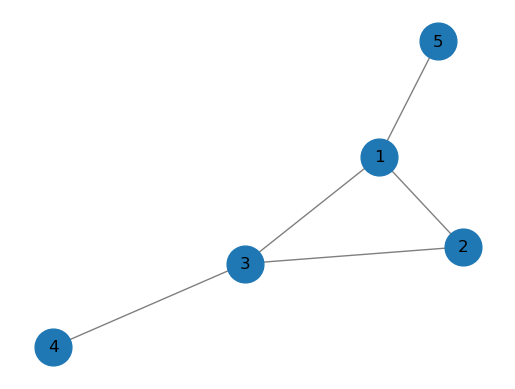

NameError: name 'heapq' is not defined

In [8]:
if __name__ == '__main__':
    # Creating the graph
    graph = Graph()
    graph.node_map = {1 : "1", 2 : "2", 3 : "3", 4 : "4", 5 : "5", 6 : "6"}
    
    # Adding nodes
    graph.G.add_node(1)
    graph.G.add_node(2)
    graph.G.add_node(3)
    graph.G.add_node(4)
    graph.G.add_node(5)
    graph.G.add_node(6)

    # Adding edges
    graph.G.add_edge(1, 2)
    graph.G.add_edge(1, 3)
    graph.G.add_edge(2, 3)
    graph.G.add_edge(3, 4)
    graph.G.add_edge(1, 5)
    graph.G.add_edge(3, 6) 

    graph.delete_edge(1, 3)
    #Visualize the graph
    graph.graph_visualize()

    #Finding the shortest path between the node 4 and 5
    print(graph.shortest_path(5,6))

In [ ]:
if __name__ == '__main__':
    rs = RandomisedSet()
    rs.add_edges_from_node(1, [5, 3, 1, 2, 6])
    print(rs.get_random_edge())
    print(rs.edges)

(1, 3)
[(1, 5), (1, 3), (1, 2), (1, 6)]
